# Harringtonine CropArray Example

---

## Notebook summary 


- Load a microscope image of video
- Tracking spots on the image and generate a pandas dataframe with the spots locations
- Creating a croparray with the image and dataframe
- Signal quantification and plotting
- Visualization of croparray with Napari

----

## Importing libraries


----

In [1]:
# To manipulate arrays
import numpy as np 
from skimage.io import imread
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()  
import pathlib # for working with windows paths
import sys
import cv2
import trackpy as tp
current_dir = pathlib.Path().absolute()
croparray_dir = current_dir.parents[0].joinpath('croparray')
sys.path.append(str(croparray_dir))
import crop_array_tools as ca
# %matplotlib inline 
plt.style.use('dark_background')

In [2]:
# Napari 
%gui qt5 
import napari
from napari.utils import nbscreenshot

## Parameters for quantification


----

In [3]:
# parameters
particle_diameter= 7  # Spot diameter : y,x size of the spot      
tracking_channel = 0          # Channel  used for tracking
min_trajectory_length = 3    # Minimal number of frames to be consider as a trajectory
max_distance_movement = 10 #particle_diameter*2
# Visualization. Static image taking a given time point. Plotting the maximum projection in Z for a given channel.
selected_channel = 0
dir = r'X:\Tim'
#img_4D_max_filename = r'MAX_Chamber02_HT_Cell01.tif'
img_4D_filename = r'Chamber02_HT_Cell02.tif'

## Loading data


----

In [4]:
# Video directory
img_file_path = os.path.join(dir,img_4D_filename)  
#img_4D_max = imread(os.path.join(dir,img_4D_max_filename))
img_4D =  imread(os.path.join(dir,img_4D_filename))

In [6]:
img_4D.shape

(36, 13, 512, 512)

In [11]:
# Converting the video to Croparray format
img_croparray = np.expand_dims(img_4D,axis=0) # expanding to include fov
img_croparray = np.expand_dims(img_croparray,axis=5)
img_croparray.shape # dimensions MUST be (fov, f , z, y, x, ch)
img_croparray.shape

print("croparray format shape [fov, f , z, y, x, ch] = ", img_croparray.shape)

croparray format shape [fov, f , z, y, x, ch] =  (1, 36, 13, 512, 512, 1)


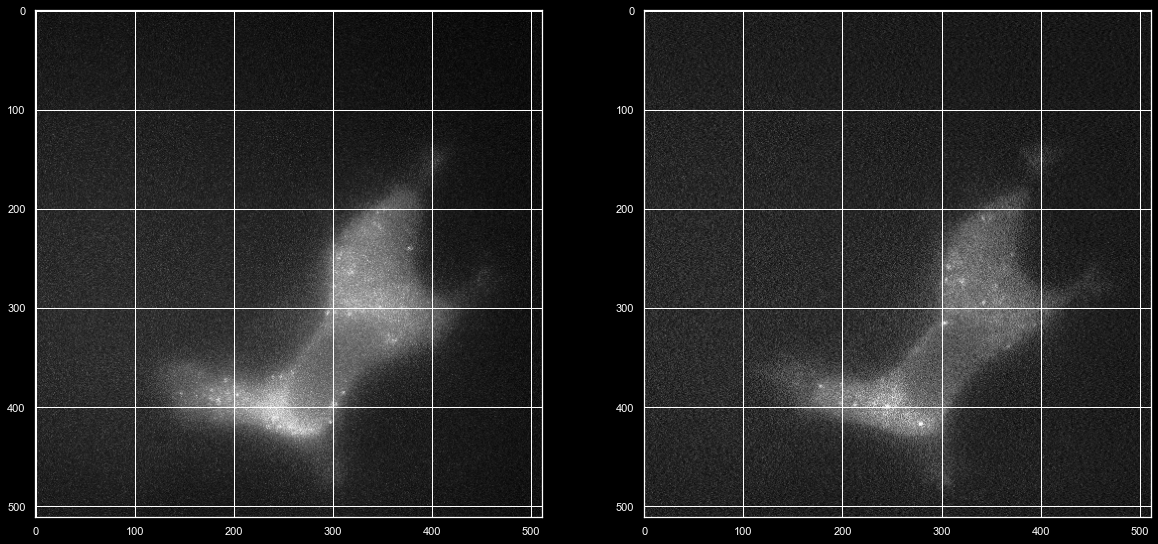

In [13]:
# plotting original image
# Just examining one of the images
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,10))
ax[0].imshow(np.max(img_croparray[0,0,:,:,:,0], axis=0),cmap='Greys_r' )
ax[1].imshow(img_croparray[0,1,6,:,:,0],cmap='Greys_r' )

## Spot detection and tracking


----

Just view video to determine what are the best z planes

In [14]:
viewer = napari.view_image(img_4D)

Now do max-projection on best-z planes

In [17]:
img_4D_max_real = np.max(img_4D[:,4:10],axis=1)
img_4D_max_real.shape

(36, 512, 512)

In [18]:
img_4D.shape,img_4D_max_real.shape

((36, 13, 512, 512), (36, 512, 512))

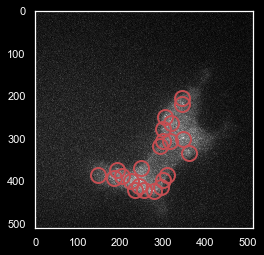

In [21]:
# Finding good settings
particle_diameter=9
f = tp.locate(img_4D_max_real[0], particle_diameter,minmass=2200)
plt.grid(False)
tp.annotate(f, img_4D_max_real[0]);

Measure signals and plot average signal through time, creating 'best_z' layer and 'signal' layer

In [22]:
f = tp.batch(img_4D_max_real, diameter=particle_diameter,minmass=2200)
f.head()
#Note, if you actually wanted to track, you could use the following:
# # link tracks
# t = tp.link(f, max_distance_movement, memory=track_skip_frames)
# t1 = tp.filter_stubs(t, min_trajectory_length)
# t1['particle'] = t1['particle']+1 # VERY IMPORTANT NOT TO HAVE TRACK IDs WITH VALUES = 0 WHEN MAKING CROP ARRAYS AS ZERO IS DEFAULT EMPTY VALUE
# # Compare the number of particles in the unfiltered and filtered data.
# print('Before:', t['particle'].nunique())
# print('After:', t1['particle'].nunique()) 

Frame 35: 14 features


,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,204.141117,344.722539,2491.123341,1.986213,0.110247,201.285275,59302.0,0.046708,0
1,218.575816,346.460741,2282.865693,2.179494,0.153482,156.859105,66041.0,0.037467,0
2,250.573697,305.224291,3278.753718,1.853846,0.158334,296.036892,69234.0,0.034256,0
3,264.386831,318.642025,3448.506483,2.304253,0.071730,207.102005,78203.0,0.027609,0
4,278.824487,300.763526,3219.975578,2.033651,0.237188,228.673984,69390.0,0.034113,0


Convert f to crop_array format

In [23]:
spots = f.copy() # Nice to copy; seems it can cause to overwrite otherwise
spots.rename(columns={'x': 'xc','y': 'yc', 'frame': 'f','signal':'signal_tp'}, inplace=True, errors='raise')
spots['fov']=0
spots['id']=spots.index
spots = spots[['fov','id','f','yc','xc','signal_tp']] # keeping signal out of curiousity... want to compare to disk-donut measurements  
spots.head()

,fov,id,f,yc,xc,signal_tp
0,0,0,0,204.141117,344.722539,201.285275
1,0,1,0,218.575816,346.460741,156.859105
2,0,2,0,250.573697,305.224291,296.036892
3,0,3,0,264.386831,318.642025,207.102005
4,0,4,0,278.824487,300.763526,228.673984


## Create Crop Array
____

Create a crop array from 4D movie

In [24]:
my_ca = ca.create_crop_array(img_croparray,spots,xy_pad=particle_diameter//2+1, dxy=130, dz=500, dt=1, units=['nm','min'])
my_ca

Original video dimensions:  (1, 36, 13, 512, 512, 1)
Padded video dimensions:  (1, 36, 13, 524, 524, 1)
Max # of spots per frame:  23
Shape of numpy array to hold all crop intensity data:  (1, 23, 36, 13, 11, 11, 1)
Shape of xc and yc numpy arrays:  (1, 23, 36, 1)
Shape of extra my_layers numpy array:  (2, 1, 23, 36)


<xarray.Dataset>
Dimensions:    (fov: 1, n: 23, t: 36, z: 13, y: 11, x: 11, ch: 1)
Coordinates:
  * fov        (fov) int32 0
  * n          (n) int16 0 1 2 3 4 5 6 7 8 9 ... 13 14 15 16 17 18 19 20 21 22
  * t          (t) int32 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35
  * z          (z) int32 0 500 1000 1500 2000 2500 ... 4000 4500 5000 5500 6000
  * y          (y) int32 -5 -4 -3 -2 -1 0 1 2 3 4 5
  * x          (x) int32 -5 -4 -3 -2 -1 0 1 2 3 4 5
  * ch         (ch) int32 0
Data variables:
    int        (fov, n, t, z, y, x, ch) int32 902 797 967 790 872 ... 0 0 0 0 0
    xc         (fov, n, t, ch) int32 351 368 365 340 339 369 358 ... 0 0 0 0 0 0
    yc         (fov, n, t, ch) int32 210 264 230 233 220 209 230 ... 0 0 0 0 0 0
    dx         int32 1
    dy         int32 1
    dz         int32 500
    dt         int32 1
    xy_pad     int32 5
    id         (fov, n, t) float64 0.0 23.0 42.0 63.0 82.0 ... 0.0 0.0 0.0 0.0
    signal_tp  (fov, n, t) float64 201.0 254.0 263.0 272.0 ... 0.0 0.0 0.0 0.0
Attributes:
    name:     video_filename
    date:     video_date

## Quantify signal intensity through time
____

In [25]:
# Measure signals and plot average signal through time, creating 'best_z' layer and 'signal' layer
ca.measure_signal(my_ca, ref_ch=0, disk_r=3, roll_n=3)


In [26]:
my_ca

<xarray.Dataset>
Dimensions:    (fov: 1, n: 23, t: 36, z: 13, y: 11, x: 11, ch: 1)
Coordinates:
  * fov        (fov) int32 0
  * n          (n) int16 0 1 2 3 4 5 6 7 8 9 ... 13 14 15 16 17 18 19 20 21 22
  * t          (t) int32 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35
  * z          (z) int32 0 500 1000 1500 2000 2500 ... 4000 4500 5000 5500 6000
  * y          (y) int32 -5 -4 -3 -2 -1 0 1 2 3 4 5
  * x          (x) int32 -5 -4 -3 -2 -1 0 1 2 3 4 5
  * ch         (ch) int64 0
Data variables: (12/13)
    int        (fov, n, t, z, y, x, ch) int32 902 797 967 790 872 ... 0 0 0 0 0
    xc         (fov, n, t, ch) int32 351 368 365 340 339 369 358 ... 0 0 0 0 0 0
    yc         (fov, n, t, ch) int32 210 264 230 233 220 209 230 ... 0 0 0 0 0 0
    dx         int32 1
    dy         int32 1
    dz         int32 500
    ...         ...
    xy_pad     int32 5
    id         (fov, n, t) float64 0.0 23.0 42.0 63.0 82.0 ... 0.0 0.0 0.0 0.0
    signal_tp  (fov, n, t) float64 201.0 254.0 263.0 272.0 ... 0.0 0.0 0.0 0.0
    zc         (fov, n, t) int64 4 7 6 6 5 4 5 7 7 4 7 ... 0 0 0 0 0 0 0 0 0 0 0
    best_z     (ch, fov, n, t, y, x) float64 -370.8 -196.8 -194.8 ... 0.0 0.0
    signal     (ch, fov, n, t) float64 120.7 232.5 257.2 194.0 ... 0.0 0.0 0.0
Attributes:
    name:     video_filename
    date:     video_date

C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1344: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(x.dtype, str):
C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1395: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(v.dtype, str):


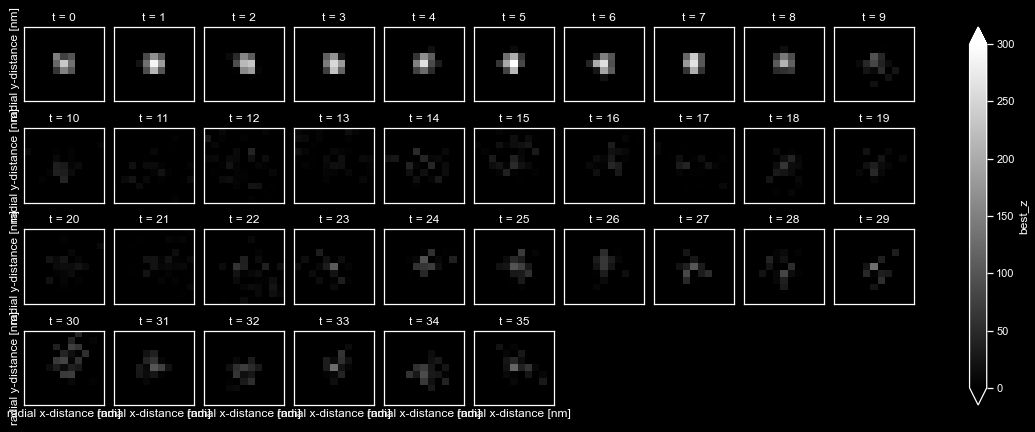

In [31]:
my_ca.best_z.mean('n').sel(fov=0,ch=0).plot.imshow(col='t',col_wrap=10,robust=True,xticks=[],yticks=[],size=1.5,cmap='gray', vmin=0, vmax =300)

Let's compare our disk-donut 'signal' layer (acquired from 3D image) to trackpy's (acquired from max-projection):

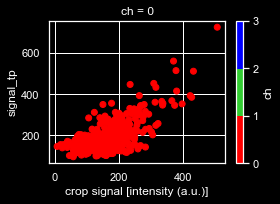

In [32]:
# Let's compare our intensity numbers to those from trackpy:
my_ca.where(my_ca.signal>0).plot.scatter(x='signal',y='signal_tp',col='ch',hue='ch',colors=['red','limegreen','blue'],levels=[0,1,2,3])

Let's look at average signal vs time

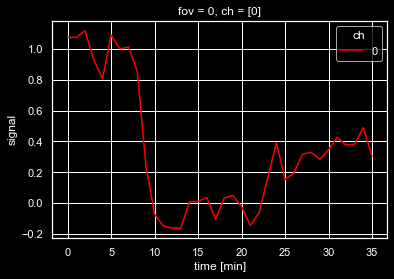

In [33]:
# Let's look at average signal vs time
start_sig = my_ca.signal.mean('n').sel(t=slice(0,4)).mean('t')
end_sig = my_ca.signal.mean('n').sel(t=slice(15,20)).mean('t')
norm_sig = (my_ca.signal.mean('n') - end_sig)/(start_sig - end_sig)
sns.set_palette(['red','limegreen','blue'])
norm_sig.sel(fov=0).plot.line(x='t',hue='ch')

Now let's just use trackpy's values:

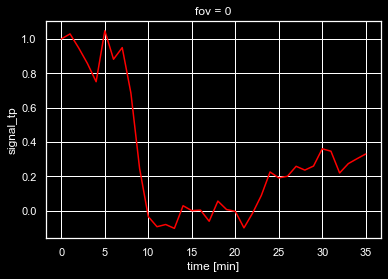

In [34]:

# Let's look at average signal vs time
start_sig = my_ca.signal_tp.mean('n').sel(t=slice(0,0)).mean('t')
end_sig = my_ca.signal_tp.mean('n').sel(t=slice(15,20)).mean('t')
norm_sig = (my_ca.signal_tp.mean('n') - end_sig)/(start_sig - end_sig)
sns.set_palette(['red','limegreen','blue'])
norm_sig.sel(fov=0).plot.line(x='t',hue='ch')

I guess trackpy and the disk donut method do a very good job at getting the intensities of spots. Although note that trackpy got the values from the max-intensity projection. Interesting.

## Visualize crop array montage with Napari
___

Now let's see a montage of the selected spots' best-z planes:

In [35]:
# view the action of montage showing an n x n crop_array through time
viewer = napari.view_image(ca.montage(my_ca.sel(fov=0,ch=0).best_z,row='n',col='t'),contrast_limits=[60,800])